## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.stats import norm

## Methods

In [2]:
def calculate_correlations_with_significance(difference_df_stylo, difference_df):
    correlation_results = {}
    p_value_symbole_results = {}
    p_value_results = {}

    for feature in difference_df_stylo["Feature"].unique():
        filtered_stylo_df = difference_df_stylo[difference_df_stylo["Feature"] == feature]

        # Calculate Pearson correlation and p-value
        correlation, p_value = pearsonr(filtered_stylo_df["Difference"], difference_df["Difference"])
        correlation_results[feature] = correlation
        p_value_results[feature] = p_value

        # Assign asterisk based on p-value significance
        if p_value < 0.01:
            p_value_symbole_results[feature] = '**'
        elif p_value < 0.05:
            p_value_symbole_results[feature] = '*'
        else:
            p_value_symbole_results[feature] = ''

    correlation_df = pd.DataFrame({
        'Feature': list(correlation_results.keys()),
        'Correlation': list(correlation_results.values()),
        'P-value_symbole': list(p_value_symbole_results.values()),  # Store significance asterisks
        'P-value': list(p_value_results.values()),
    })

    return correlation_df

In [3]:
def fisher_z(r):
  return 0.5 * np.log((1 + r) / (1 - r))

In [4]:
def compare_correlations(r1, n1, r2, n2):
  """
  r1, r2 : Fischer transformed correlations
  n1, n2 : sample size
  """
  z1 = fisher_z(r1)
  z2 = fisher_z(r2)
  se = np.sqrt(1/(n1 - 3) + 1/(n2 - 3))
  z = np.abs(z1 - z2) / se
  p = 2 * (1 - norm.cdf(z)) # two-tailed
  return z, p
# Example usage:
# z_score, p_value = compare_correlations(0.65, 96, 0.45, 96)

In [5]:
def tost_compare_correlations_z(r1, n1, r2, n2, delta_z=0.01, alpha=0.05):
    """
    TOST equivalence test for two correlations (in Fisher z-space).

    Returns:
        p1, p2 : one-sided p-values
        equivalent : True if both p-values < alpha
    """
    z1 = fisher_z(r1)
    z2 = fisher_z(r2)
    diff = z1 - z2
    print(f"Difference in z-space: {diff:.3f}")
    se = np.sqrt(1 / (n1 - 3) + 1 / (n2 - 3))

    z_stat_low = (diff + delta_z) / se
    z_stat_high = (diff - delta_z) / se

    # CORRECTED: Flip these p-values
    p1 = 1 - norm.cdf(z_stat_low)  # test: diff > -delta
    p2 = norm.cdf(z_stat_high)     # test: diff < delta

    equivalent = (p1 < alpha) and (p2 < alpha)
    return p1, p2, equivalent

def r_to_z_delta(delta_r):
    r = 0.0  # center at 0 to be conservative
    r1 = min(max(r - delta_r, -0.9999), 0.9999)
    r2 = min(max(r + delta_r, -0.9999), 0.9999)
    return np.abs(fisher_z(r2) - fisher_z(r1))

## Dataset

### Stylometry

In [6]:
stylo_df = pd.read_excel('./stylo_terreau_df.xlsx')

In [7]:
stylo_df_tuffery_ref_fr = stylo_df[stylo_df['author'] == "Tuffery"]

stylo_df_style_ref_fr = stylo_df[stylo_df['genAI'] == "No"]
stylo_df_style_ref_fr = stylo_df_style_ref_fr[stylo_df_style_ref_fr['author'] != "Tuffery"]

stylo_df_TS_ref_fr = pd.concat([stylo_df_tuffery_ref_fr, stylo_df_style_ref_fr], axis=0)

stylo_df_TS_ref_fr = stylo_df_TS_ref_fr.rename(columns={"id": "file_name", "Unnamed: 0":"id"})
stylo_df_TS_ref_fr = stylo_df_TS_ref_fr.rename(columns={'Indexes': 'Entropy'})

stylo_df_TS_ref_fr["class"] = stylo_df_TS_ref_fr["author"].map({"Tuffery": "A1", "Proust": "B1", "Celine": "B1", "Yourcenar":"B1"})

stylo_df = stylo_df_TS_ref_fr

In [8]:
stylo_df.head()

,id,author,genAI,Punctuation,TAG,Structural,Entropy,NER,Letters,text_id,file_name,class
960,960,Tuffery,No,0.019510,0.195833,8.794737,7.159736,0.083333,0.029505,0,tuffery_agitato_atrabile.txt,A1
961,961,Tuffery,No,0.011617,0.436869,22.038070,7.771713,0.454545,0.029591,1,tuffery_agitato_lamentabile.txt,A1
962,962,Tuffery,No,0.011944,0.407407,18.214147,6.612949,0.222222,0.028414,2,tuffery_anacephaleose.txt,A1
963,963,Tuffery,No,0.011217,0.200617,9.133420,6.714099,0.092593,0.028595,3,tuffery_anadiploses_epanadiploses.txt,A1
964,964,Tuffery,No,0.010989,1.333333,59.190000,5.093733,1.000000,0.031382,4,tuffery_anaphore.txt,A1


In [9]:
#Normalize and compute the mean of features 

numeric_cols = stylo_df.select_dtypes(include=['number']).columns  # Get numeric columns

for col in numeric_cols:
    stylo_df[f"{col}_normalized"] = (stylo_df[col] - stylo_df[col].min()) / (stylo_df[col].max() - stylo_df[col].min())

#Mean
columns_to_average = ["Structural_normalized",
                      "Letters_normalized",
                      "TAG_normalized",
                      "NER_normalized",
                       "Entropy_normalized",
                      ]
stylo_df["Mean"] = stylo_df[columns_to_average].mean(axis=1)

In [10]:
df_subset = stylo_df[["author"] + columns_to_average]

mean_by_author = df_subset.groupby("author").mean(numeric_only=True)

mean_by_author = mean_by_author.T

mean_by_author = mean_by_author.rename_axis("feature", axis="columns")
mean_by_author = mean_by_author[['Tuffery', 'Proust', 'Celine', 'Yourcenar']]
mean_by_author.index = mean_by_author.index.str.replace('_normalized', '', regex=False)

mean_by_author.loc["Mean"] = mean_by_author.mean(numeric_only=True)

mean_by_author

feature,Tuffery,Proust,Celine,Yourcenar
Structural,0.054095,0.154980,0.032130,0.058004
Letters,0.284825,0.251919,0.252227,0.275529
TAG,0.056540,0.143150,0.032347,0.041741
NER,0.044785,0.155766,0.040569,0.070331
Entropy,0.469363,0.524524,0.474654,0.589203
Mean,0.181922,0.246068,0.166385,0.206961


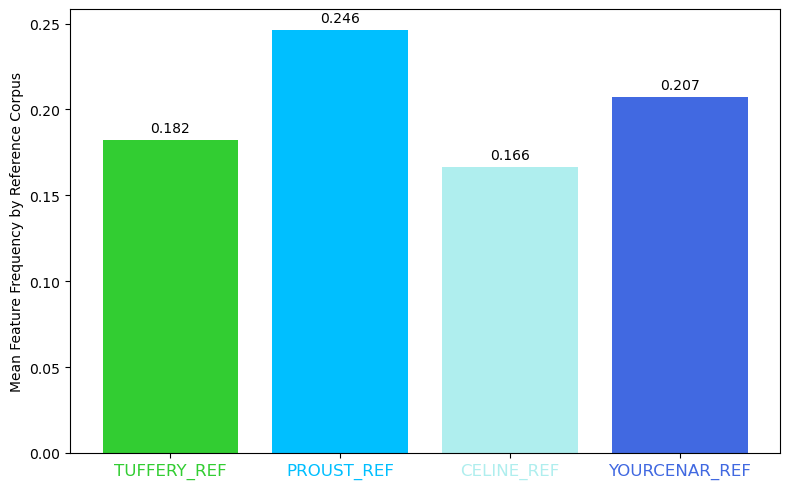

In [11]:
# Extract the Mean row
mean_values = mean_by_author.loc["Mean"]

# Define custom colors in the same order as your columns
colors = {
    "Tuffery": "limegreen",
    "Proust": "deepskyblue",
    "Celine": "paleturquoise",
    "Yourcenar": "royalblue"
}


labels = {
    "Tuffery": "TUFFERY_REF",
    "Proust": "PROUST_REF",
    "Celine": "CELINE_REF",
    "Yourcenar": "YOURCENAR_REF"
}

# Create bar plot with custom colors
plt.figure(figsize=(8, 5))
plt.bar(mean_values.index, mean_values.values,
        color=[colors[author] for author in mean_values.index])

plt.xticks(ticks=range(len(mean_values.index)),
           labels=[labels[author] for author in mean_values.index],
           fontsize=12)

# Get the current tick label Text objects
tick_texts = plt.gca().get_xticklabels()

# Set individual colors
for i, author in enumerate(mean_values.index):
    tick_texts[i].set_color(colors[author])

# Add labels and title
plt.ylabel("Mean Feature Frequency by Reference Corpus")

# Add value labels on top of bars
for i, v in enumerate(mean_values.values):
    plt.text(i, v+0.003, f"{v:.3f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()

### Distance between embeddings

In [12]:
mean_distances_df = pd.read_excel('./distance_pertext_umap_TS_ref.xlsx')

mean_distances_df["genAI"] = mean_distances_df["Class"].map({"Proust": "No", "Celine": "No", "Yourcenar": "No", "Tuffery": "No",
                                                             "Proust_mistral": "mistral", "Celine_mistral": "mistral", "Yourcenar_mistral": "mistral",
                                                             "Proust_gpt": "gpt", "Celine_gpt": "gpt", "Yourcenar_gpt": "gpt",
                                                             "Proust_gemini": "gemini", "Celine_gemini": "gemini", "Yourcenar_gemini": "gemini",
                                                             })

mean_distances_df["author"] = mean_distances_df["Class"].map({"Proust": "Proust", "Celine": "Celine", "Yourcenar": "Yourcenar","Tuffery": "Tuffery",
                                                             "Proust_mistral": "Proust", "Celine_mistral": "Celine", "Yourcenar_mistral": "Yourcenar",
                                                             "Proust_gpt": "Proust", "Celine_gpt": "Celine", "Yourcenar_gpt": "Yourcenar",
                                                             "Proust_gemini": "Proust", "Celine_gemini": "Celine", "Yourcenar_gemini": "Yourcenar",
                                                             })

mean_distances_df["class"] = mean_distances_df["author"].map({"Tuffery": "A1", "Proust": "B1", "Celine": "B1", "Yourcenar":"B1"})
mean_distances_df = mean_distances_df.drop(columns=["Class"])

In [13]:
mean_distances_df.head()

,Text_Index,Mean_Distance_From_Centroid,genAI,author,class
0,0,1.493536,No,Tuffery,A1
1,1,3.086941,No,Tuffery,A1
2,2,1.641952,No,Tuffery,A1
3,3,1.457144,No,Tuffery,A1
4,4,1.759076,No,Tuffery,A1


## Aggregated features, per author : correlation, p-value

In [14]:
#### DISPERSION DELTA ANALYSIS FOR 2 COMPARISONS

# Dispersion delta
Tuffery_distances = mean_distances_df[mean_distances_df['author'] == 'Tuffery']['Mean_Distance_From_Centroid'].values

GenAI_distances = {}
difference_df_cond1 = {}

for auteur in ["Proust", "Celine", "Yourcenar"]:
    GenAI_distances[auteur] = mean_distances_df[mean_distances_df['author'] == auteur]['Mean_Distance_From_Centroid'].values
    # List to store the results
    difference_results = []

    for i, ref_dist in enumerate(Tuffery_distances):
        for j, gen_dist in enumerate(GenAI_distances[auteur]):
            difference = ref_dist - gen_dist
            difference_results.append({
                'Tuffery_Index': i,
                f'{auteur}_Index': j,
                'Difference': difference
            })

    difference_df_cond1[auteur] = pd.DataFrame(difference_results)



In [15]:
# Style delta calculation

Tuffery_df = stylo_df[stylo_df['author'] == 'Tuffery']

GenAI_stylo = {}
difference_df_stylo_cond1 = {}

# List of stylistic features
# features = ['Function words', 'Letters', 'Numbers', 'TAG', 'NER', 'Structural', 'Punctuation', 'Entropy']
features = ['Mean']

for auteur in ["Celine", "Proust", "Yourcenar"]:
    GenAI_stylo[auteur] = stylo_df[stylo_df['author'] == auteur]

    # List to store the results
    difference_results_stylo = []

    for feature in features:
        for i, ref_val in enumerate(Tuffery_df[feature].values):
            for j, gen_val in enumerate(GenAI_stylo[auteur][feature].values):
                difference = ref_val - gen_val
                difference_results_stylo.append({
                    'Feature': feature,
                    'Mistral_Index': i,
                    f'{auteur}_Index': j,
                    'Difference': difference
                })
    difference_df_stylo_cond1[auteur] = pd.DataFrame(difference_results_stylo)


In [16]:
for auteur in ["Proust", "Celine", "Yourcenar"]:

    correlation_df_cond1 = calculate_correlations_with_significance(difference_df_stylo_cond1[auteur], difference_df_cond1[auteur])

    print(f"{auteur}")
    print(correlation_df_cond1.to_string())

Proust
  Feature  Correlation P-value_symbole       P-value
0    Mean     0.186075              **  1.399222e-72
Celine
  Feature  Correlation P-value_symbole       P-value
0    Mean     0.159404              **  1.656137e-53
Yourcenar
  Feature  Correlation P-value_symbole       P-value
0    Mean     0.086404              **  9.637181e-17


## Per feature, per author : correlation, p-value

In [17]:
#### DISPERSION DELTA ANALYSIS FOR 2 COMPARISONS


## Humans vs genAI

# Dispersion delta
Tuffery_distances = mean_distances_df[mean_distances_df['author'] == 'Tuffery']['Mean_Distance_From_Centroid'].values

GenAI_distances = {}
difference_df_cond1 = {}


for auteur in ["Proust", "Celine", "Yourcenar"]:
    GenAI_distances[auteur] = mean_distances_df[mean_distances_df['author'] == auteur]['Mean_Distance_From_Centroid'].values

    # List to store the results
    difference_results = []

    for i, ref_dist in enumerate(Tuffery_distances):
        for j, gen_dist in enumerate(GenAI_distances[auteur]):
            difference = ref_dist - gen_dist
            difference_results.append({
                'Tuffery_Index': i,
                f'{auteur}_Index': j,
                'Difference': difference
            })

    difference_df_cond1[auteur] = pd.DataFrame(difference_results)



In [18]:
# Style delta calculation

Tuffery_df = stylo_df[stylo_df['author'] == 'Tuffery']

GenAI_stylo = {}
difference_df_stylo_cond1 = {}

# List of stylistic features
#features = ['Function words', 'Letters', 'Numbers', 'TAG', 'NER', 'Structural', 'Punctuation', 'Indexes']
features = ['Letters', 'TAG', 'NER', 'Structural', 'Entropy']
# features = ['Mean']

for auteur in ["Proust", "Celine", "Yourcenar"]:
    GenAI_stylo[auteur] = stylo_df[stylo_df['author'] == auteur]

    # List to store the results
    difference_results_stylo = []

    for feature in features:
        for i, ref_val in enumerate(Tuffery_df[feature].values):
            for j, gen_val in enumerate(GenAI_stylo[auteur][feature].values):
                difference = ref_val - gen_val
                difference_results_stylo.append({
                    'Feature': feature,
                    'Mistral_Index': i,
                    f'{auteur}_Index': j,
                    'Difference': difference
                })
    difference_df_stylo_cond1[auteur] = pd.DataFrame(difference_results_stylo)

In [19]:
for auteur in ["Proust", "Celine", "Yourcenar"]:

    correlation_df_cond1 = calculate_correlations_with_significance(difference_df_stylo_cond1[auteur], difference_df_cond1[auteur])

    print(f"\n{auteur}\n")
    print(correlation_df_cond1.to_string())


Proust

      Feature  Correlation P-value_symbole       P-value
0     Letters     0.162653              **  1.149980e-55
1         TAG     0.127352              **  1.246612e-34
2         NER     0.195370              **  5.789288e-80
3  Structural     0.135972              **  2.793552e-39
4     Entropy     0.013114                  2.081026e-01

Celine

      Feature  Correlation P-value_symbole       P-value
0     Letters     0.161415              **  7.736992e-55
1         TAG     0.004683                  6.530689e-01
2         NER     0.132148              **  3.528125e-37
3  Structural     0.011195                  2.825510e-01
4     Entropy     0.104475              **  8.666099e-24

Yourcenar

      Feature  Correlation P-value_symbole       P-value
0     Letters     0.055860              **  8.049916e-08
1         TAG    -0.004307                  6.793163e-01
2         NER     0.212397              **  1.703754e-94
3  Structural    -0.004648                  6.554719e-01
4